In [28]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
import datetime
from helpers import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load the training data into feature matrix, class labels, and event ids:

In [41]:
from proj1_helpers import *
DATA_TRAIN_PATH = '../../train.csv' # TODO: download train data and supply path here 
y_starting, tX_starting, ids = load_csv_data(DATA_TRAIN_PATH,sub_sample=False)

# Pandas

In [3]:
import pandas as pd

In [4]:
# General data description
pd_data=pd.read_csv(DATA_TRAIN_PATH)
pd_data=pd_data.replace({'s':1,'b':-1})
del pd_data['Id']
pd_data.Prediction.describe()

count    250000.000000
mean         -0.314664
std           0.949205
min          -1.000000
25%          -1.000000
50%          -1.000000
75%           1.000000
max           1.000000
Name: Prediction, dtype: float64

In [ ]:
# Number of nan
pd_data[pd_data==-999].count()

In [ ]:
# Correlation matrix
pd_data2=pd_data.replace({-999:0})
corr_matrix2=pd_data2.corr()
corr_matrix2.Prediction

In [ ]:
pd_data3=pd_data.replace({-999:-10})
corr_matrix3=pd_data3.corr()

In [ ]:
corr_matrix=pd_data.corr()
corr_matrix.Prediction


In [ ]:
synthesis=corr_matrix[['Prediction']].copy()
synthesis['PredictionCorrected']=corr_matrix2.Prediction
synthesis['PredictionNan-10']=corr_matrix3.Prediction
synthesis['id']=range(-1,synthesis.shape[0]-1)
synthesis

In [ ]:
plt.matshow(pd_data2.corr())

In [ ]:
plt.scatter(pd_data2[[24]],pd_data2[[22]])

# Data analysis

In [ ]:
names=pd_data.columns.values

for i in range(tX_starting.shape[1]):
    plt.figure()
    plt.title(names[i+1]+" "+str(i))
    plt.hist(tX_starting[:,i],bins=70)

In [ ]:
names=pd_data.columns.values

for i in range(tX_starting.shape[1]):
    plt.figure()
    plt.title(names[i+1]+" "+str(i))
    plt.boxplot(tX_starting[:,i])

# Splitting data

In [59]:
def split_data(x, y, ratio, seed=1):
    """split the dataset based on the split ratio."""
    # set seed
    np.random.seed(seed)
    print(x.shape)
    train_elements=int(ratio*x.shape[0])
    test_elements=x.shape[0]-train_elements
    print(train_elements,test_elements)
    indices = np.random.permutation(x.shape[0])
    training_idx, test_idx = indices[:train_elements], indices[train_elements:]
    x_train, x_test = x[training_idx], x[test_idx]
    y_train, y_test = y[training_idx], y[test_idx]
    return x_train,x_test,y_train,y_test

In [60]:
tX,tX_test,y,y_test=split_data(tX_starting,y_starting,0.5,1)
tX_test.shape

(250000, 30)
125000 125000


(125000, 30)

In [61]:
tX.shape

(125000, 30)

# Preprocessing

### Delete columns with low correlation

In [46]:
def drop_col(tX_starting):
    drop_columns=[]
    #for i in range(tX_starting.shape[1]):
    #    coeff=np.corrcoef(y,tX_starting[:,i])[0,1]
    #    if abs(coeff)<0.000:
    #        drop_columns.append(i)


    tX=np.delete(tX_starting,drop_columns,axis=1)
    return tX
    

In [47]:
def replace_nan(tX_starting):
    tX=tX_starting.copy()
    nan_position=[tX[:,[0,4,23]]!=-999][0]*1

    for col in range(tX.shape[1]):
        column=tX[:,col][tX[:,col]!=-999]
        mean=column.mean()
        median=np.median(column)

        tX[:,col][tX[:,col]==-999]=median    
    
    return nan_position,tX
    

### Categorical variables

In [36]:
def categorical_variables(tX_starting):
    tX=tX_starting.copy()
    
    cat_variable=22
    values=[0,1,2]

    added_matrix=np.zeros([tX.shape[0],3])
    added_matrix[:,0]=np.array([tX[:,22]==0])
    added_matrix[:,1]=np.array([tX[:,22]==1])
    added_matrix[:,2]=np.array([tX[:,22]==2])
    
    tX=np.delete(tX,[22],axis=1)
    print(tX.shape)
    
    return added_matrix,tX

In [37]:
def before_poly(tX_starting):
    tX=drop_col(tX_starting)
    nan_position,tX=replace_nan(tX)
    added_matrix,tX=categorical_variables(tX)
    full_added_matrix=np.concatenate((added_matrix,nan_position),axis=1)
    return full_added_matrix,tX

In [19]:
full_added_matrix,tX=before_poly(tX_starting)

(250000, 29)


### Polynomial regression

In [38]:
def build_poly(tX,degree,y,prod_to_exclude=False,train=True,columns_to_consider=False,exponential=False,cross_products=False,added_matrix_for_cross=False,threshold_power=0.0,threshold_cross=0.00):
    if not columns_to_consider:
        columns_to_consider=range(tX.shape[1])
    if not prod_to_exclude:
        prod_to_exclude=[]
    columns_to_consider=np.array(columns_to_consider)
    # Add power of the matrix
    final_list=[]
    for i in range(2,degree+1):
        #corr=np.corrcoef(tX[:,columns_to_consider]**i,y,rowvar=0)[:-1,-1]
        #cols=abs(corr)>threshold_power
        #cols=columns_to_consider[cols]
        cols=columns_to_consider
        tX=np.concatenate((tX,tX[:,cols]**i),axis=1)
    if exponential:
        tX=np.concatenate((tX,np.exp(tX[:,cols]/100)),axis=1)
#        tX=np.concatenate((tX,np.exp(tX[:,cols]/80)),axis=1)
#        tX=np.concatenate((tX,np.exp(tX[:,cols]/60)),axis=1)
        tX=np.concatenate((tX,np.exp(tX[:,cols]/50)),axis=1)
        tX=np.concatenate((tX,np.exp(tX[:,cols]/40)),axis=1)
        tX=np.concatenate((tX,np.exp(tX[:,cols]/20)),axis=1)
    if cross_products:
        if added_matrix_for_cross.any():
            # Add to columns to consider
            for i in range(tX.shape[1],tX.shape[1]+added_matrix_for_cross.shape[1]):
                columns_to_consider=np.append(columns_to_consider,i)
            # Concatenate
            tX=np.concatenate((tX,added_matrix_for_cross),axis=1)
            final_list.append(tX)
        for i,col1 in enumerate(columns_to_consider):
            for j,col2 in enumerate(columns_to_consider):
                if j>i and (i,j) not in prod_to_exclude:
                    if train:
                        prod=tX[:,col1]*tX[:,col2]
                        corr=np.corrcoef(prod,y)[0,1]
                        if abs(corr)>threshold_cross:
                            final_list.append(prod.reshape([prod.shape[0],1]))
                        else:
                            prod_to_exclude.append((i,j))
                    else:
                        prod=tX[:,col1]*tX[:,col2]
                        final_list.append(prod.reshape([prod.shape[0],1]))
        final_tuple=tuple(final_list)
        tX=np.concatenate(final_tuple,axis=1)
    return tX,prod_to_exclude

In [39]:
tX=build_poly(tX,10,y,exponential=True,cross_products=True,added_matrix_for_cross=full_added_matrix,threshold_cross=0.0)
tX.shape

ValueError: all the input array dimensions except for the concatenation axis must match exactly

### Normalizing

In [21]:
def normalize(tX):# Normalizing
    mean=np.sum(tX,axis=0)/tX.shape[0]
    std=np.sqrt(np.sum(tX**2,axis=0)/tX.shape[0])
    tX=(tX-mean)/std
    return tX

In [22]:
def add_ones(tX_starting):
    ones=np.ones(tX_starting.shape[0]).reshape([tX_starting.shape[0],1])
    tX=np.concatenate((tX_starting,ones),axis=1)
    return tX

In [62]:
def process_data(tX_starting,prod_to_exclude=False,train=True):
    full_added_matrix,tX=before_poly(tX_starting)
    tX,prod_to_exclude=build_poly(tX,10,y,train=train,prod_to_exclude=prod_to_exclude,exponential=True,cross_products=False,added_matrix_for_cross=full_added_matrix,threshold_cross=0.0)
    tX=normalize(tX)
    tX=add_ones(tX)
    return tX,prod_to_exclude
    
tX,prod_to_exclude=process_data(tX)
tX_test,null_variable=process_data(tX_test)

(125000, 29)
(125000, 29)


In [63]:
tX.shape

(125000, 407)

In [64]:
prod_to_exclude

[]

## Do your thing crazy machine learning thing here :) ...

In [51]:
def compute_predictions(tX,w):
    prediction=tX.dot(w)
    prediction[np.where(prediction <= 0)] = -1
    prediction[np.where(prediction > 0)] = 1
    return prediction

In [52]:
def evaluate_prediction(prediction,y):
    return (sum(y*prediction)/y.shape[0]+1)/2

In [53]:
def evaluate(y,tX,w):
    prediction=compute_predictions(tX,w)
    return evaluate_prediction(prediction,y)

In [54]:
def compute_loss(y, tX, w):
    """Calculate the loss.

    You can calculate the loss using mse or mae.
    """
    error= y-tX.dot(w)
    square=np.sum(error**2)/error.shape[0]
    return square

In [55]:
def compute_gradient(y, tX, w):
    """Compute the gradient."""
    N=tX.shape[0]
    error=y-tX.dot(w)
    gradient=-1.0/N*(np.transpose(tX).dot(error))
    return gradient
        
compute_gradient(y_train,tX_train,np.zeros([tX_train.shape[1]])).shape

NameError: name 'y_train' is not defined

In [ ]:
def gradient_descent(y, tX, initial_w, max_iters, gamma): 
    """Gradient descent algorithm."""
    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w
    for n_iter in range(max_iters):
        # Compute gradient and loss
        gradient=compute_gradient(y,tX,w)
        loss=compute_loss(y,tX,w)
        # Update w by gradient
        w=w-gamma*gradient
        # store w and loss
        ws.append(np.copy(w))
        losses.append(loss)
        print("Gradient Descent({bi}/{ti}): loss={l}".format(
              bi=n_iter, ti=max_iters - 1, l=loss))

    print(w.shape)
    return loss, w

In [ ]:
def compute_stoch_gradient(y, tx, w):
    """Compute a stochastic gradient for batch data."""
    N=tx.shape[0]
    error=y-tx.dot(w)
    gradient=-1.0/N*(np.transpose(tx).dot(error))
    return gradient


def stochastic_gradient_descent(y, tx, initial_w, batch_size, max_epochs, gamma):
    """Stochastic gradient descent algorithm."""
    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w
    y_shuffle=[]
    tx_shuffle=[]
    for minibatch_y, minibatch_tx in batch_iter(y, tx, batch_size):
        y_shuffle.append(minibatch_y)
        tx_shuffle.append(minibatch_tx)
    for n_iter in range(max_epochs):
        # compute stochastic gradient
        gradient=compute_stoch_gradient(y_shuffle[n_iter],tx_shuffle[n_iter],w)
        loss=compute_loss(y,tx,w)
        # update w
        w=w-gamma*gradient
        # store w and loss
        ws.append(np.copy(w))
        losses.append(loss)
        print("Gradient Descent({bi}/{ti}): loss={l}, w0={w0}, w1={w1}".format(
              bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]))

    return loss, w

In [ ]:
# Define the parameters of the algorithm.
max_iters = 50
gamma = 0.00001

# Initialization
w_initial = np.ones(tX.shape[1])

# Start gradient descent.
start_time = datetime.datetime.now()
gradient_losses, w = gradient_descent(y, tX, w_initial, max_iters, gamma)
#gradient_losses, w = stochastic_gradient_descent(y_train, tX_train, w_initial,30, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("Gradient Descent: execution time={t:.3f} seconds".format(t=exection_time))

print(sum((y_test-tX_test.dot(w))**2)/tX_test.shape[0])

In [65]:
def least_squares(y, tx):
    """calculate the least squares solution."""
    # returns mse, and optimal weights
    
    w=np.linalg.solve(tx.T.dot(tx),tx.T.dot(y))
    mse=sum((y-tx.dot(w))**2)/tx.shape[0]
    
    return mse,w

mse,w=least_squares(y,tX)
print(evaluate(y,tX,w))
print(evaluate(y_test,tX_test,w))

0.820448
0.388704


In [67]:
def ridge_regression(y, tx, lamb):
    """implement ridge regression."""
    # ***************************************************
    # INSERT YOUR CODE HERE
    # ridge regression: TODO
    # ***************************************************
    w=np.linalg.solve(tx.T.dot(tx)+lamb**2*np.identity(tx.shape[1]),tx.T.dot(y))
    #mse=sum((y-tx.dot(w))**2)/tx.shape[0]
    return 1,w

mse,w=ridge_regression(y,tX,0)

0
10
20
30
40
50
60
70
80
90
100


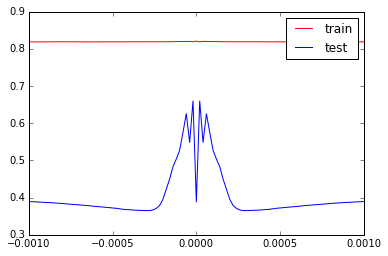

In [68]:
perc_tr=[]
perc_te=[]

lambdas = np.linspace(-0.001,0.001,101)
for i,lamb in enumerate(lambdas):
    mse,w=ridge_regression(y,tX,lamb)
    
    perc_tr.append(evaluate(y,tX,w))
    perc_te.append(evaluate(y_test,tX_test,w))
    
    if i%10==0:
        print(i)

plt.plot(lambdas,perc_tr,label='train',color='r')
plt.plot(lambdas,perc_te,label='test')
plt.legend()

In [70]:
print(np.amax(perc_te))
print(np.median(perc_te))
b=np.argmax(perc_te)
best_lamb=lambdas[b]
best_lamb
mse,w=ridge_regression(y,tX,best_lamb)
w.shape

0.659648
0.381192


(407,)

## Best so far
- Degree 10 - 4 exp - all done, ridge regression: 0.82956
- Degree 10 - 3 exp - all done, ridge regression: 0.829008
- Degree 14 - 2 exp - all done, ridge regression: 0.82896
- Degree 12 - 2 exp - all done, ridge regression: 0.828936
- Degree 12 - all done, ridge regression: 0.828784
- Degree 10 - 2 exp - all done, ridge regression: 0.828408
- Degree 10 - exp - all done, ridge regression: 0.827816
- Degree 10 - all done, ridge regression: 0.82717600000000002
- Degree 6 - all done, ridge regression: 0.81543199999999993
- Degree 8 - all done, ridge regression: 0.82291999999999998

In [ ]:
# Basic implementation of logistic regression using the least squares
def logistic_regression(y,tx,tx_test,threshold=0.5):
    mse,w=least_squares(y,tx)
    
    y_prev=tx.dot(w)
    y_prev=1/(1+np.exp(-y_prev))
    output_train=np.ones(y_prev.shape[0])
    output_train[np.where(y_prev<threshold)] = -1
    
    y_test=tx_test.dot(w)
    y_test=1/(1+np.exp(-y_test))
    output_test=np.ones(y_test.shape[0])
    output_test[np.where(y_test<threshold)] = -1
    
    return output_train,output_test

thresholds=np.linspace(0.48,0.52,101)
perc_log_tr=[]
perc_log_te=[]
for threshold in thresholds:
    output_train,output_test=logistic_regression(y_train,tX_train,tX_test,threshold)
    perc_log_tr.append(evaluate_prediction(output_train,y_train))
    perc_log_te.append(evaluate_prediction(output_test,y_test))

    
plt.plot(thresholds,perc_log_tr,'r',label='Train')
plt.plot(thresholds,perc_log_te,'b',label='Test')
plt.legend()

# Test on training dataset

In [ ]:
tX_test_post=np.copy(tX_test)
tX_test_post[tX_test_post==-999]=0
prediction=compute_predictions(tX_test,w)
evaluate_prediction(prediction,y_test)

In [ ]:
print(sum((y_test-tX_test.dot(w))**2)/tX_test.shape[0])
print(tX_test.dot(w))

## Generate predictions and save ouput in csv format for submission:

In [26]:
DATA_TEST_PATH = '../../test.csv' # TODO: download train data and supply path here 
_, tX_final_test, ids_test = load_csv_data(DATA_TEST_PATH)

In [ ]:
tX_final_test=build_poly(tX_final_test,6)

In [45]:
tX_final=process_data(tX_final_test,prod_to_exclude=prod_to_exclude,train=False)

(568238, 29)


In [46]:
tX_final[0].shape

(568238, 407)

In [47]:
OUTPUT_PATH = '../../predictions.csv' # TODO: fill in desired name of output file for submission
y_pred = predict_labels(w, tX_final[0])
#y_train,y_test = logistic_regression(y_train,tX_train,tX_final_test,0.48)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)
print(y_pred)

[-1. -1.  1. ..., -1. -1. -1.]
